In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
# To suppress a specific warning by category (e.g., FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import export_graphviz
import matplotlib as mp
import matplotlib.pyplot as plt
import graphviz as gp
from sklearn import decomposition as dcp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score,mean_squared_error, confusion_matrix

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test=pd.read_csv("/kaggle/input/titanic/test.csv")

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:

test_data=pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
#a function to analyze the problems and features of data

def check_data_quality(data):
    # Check for duplicate rows
    duplicate_rows = data[data.duplicated()]
    
    # Check for missing values
    missing_values = data.isnull().sum()
    
    # Get data types and missing value status for each column header
    column_info = []
    for column in data.columns:
        column_type = data[column].dtype
        has_missing_values = missing_values[column] > 0
        missing_value_count = missing_values[column]
        unique_val_count=len(data[column].unique())
        column_info.append((column, column_type, has_missing_values,missing_value_count,unique_val_count))
    
    # Return the results
    if len(duplicate_rows) > 0:
        print( "Duplicate Rows Found:\n", duplicate_rows)
    else:
        print( "No Duplicate Rows Found.")
    print("shape of the data is:",data.shape)
    
    return  pd.DataFrame(column_info, columns=["Column", "Data_Type", "Missing_Values","Missing_Count","unique_val_count"])


In [6]:
check_data_quality(train_data)


No Duplicate Rows Found.
shape of the data is: (891, 12)


,Column,Data_Type,Missing_Values,Missing_Count,unique_val_count
0,PassengerId,int64,False,0,891
1,Survived,int64,False,0,2
2,Pclass,int64,False,0,3
3,Name,object,False,0,891
4,Sex,object,False,0,2
5,Age,float64,True,177,89
6,SibSp,int64,False,0,7
7,Parch,int64,False,0,7
8,Ticket,object,False,0,681
9,Fare,float64,False,0,248


In [7]:
check_data_quality(test)


No Duplicate Rows Found.
shape of the data is: (418, 11)


,Column,Data_Type,Missing_Values,Missing_Count,unique_val_count
0,PassengerId,int64,False,0,418
1,Pclass,int64,False,0,3
2,Name,object,False,0,418
3,Sex,object,False,0,2
4,Age,float64,True,86,80
5,SibSp,int64,False,0,7
6,Parch,int64,False,0,8
7,Ticket,object,False,0,363
8,Fare,float64,True,1,170
9,Cabin,object,True,327,77


In [8]:
train_data[train_data["Cabin"].notnull()]["Cabin"].unique()

array(['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104',
       'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30',
       'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22',
       'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20',
       'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126',
       'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64',
       'E24

In [9]:
train_data["Ticket"]

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [10]:
train_data["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

Age values may be imputed but cabin has too many missing values and ticket number and passengerID does not add any viaribility so dropping those.

In [11]:
train=train_data.drop(["Cabin","Ticket","PassengerId"], axis=1)
test=test.drop(["Cabin","Ticket","PassengerId"], axis=1)

In [12]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


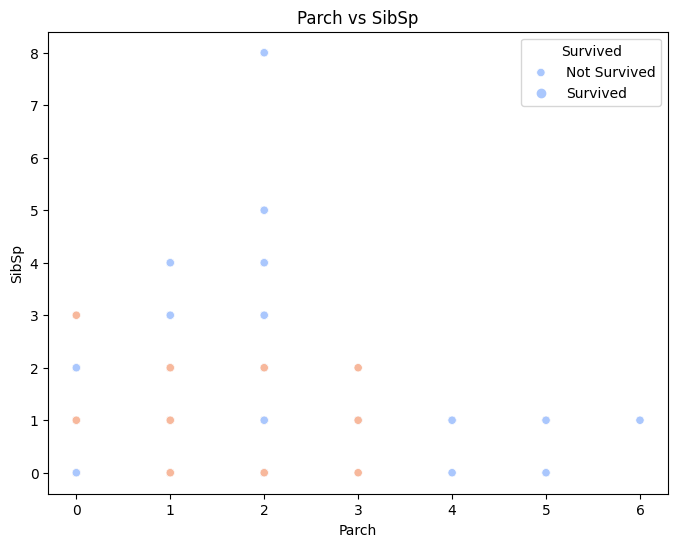

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# sibsp	# of siblings / spouses aboard the Titanic	
# parch	# of parents / children aboard the Titanic	

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Parch", y="SibSp", data=train_data, hue="Survived", palette="coolwarm")
plt.title("Parch vs SibSp")
plt.xlabel("Parch")
plt.ylabel("SibSp")
plt.legend(title="Survived", loc="upper right", labels=["Not Survived", "Survived"])
plt.show()

In [14]:
train.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


Although SibSp and Parch column looks similar and from the above graph and correlation we see inverse relationship, but correlation value is only 0.41, hence keeping both. 

Using the same logic keeping both of Pclass and Fare

In [15]:


# Extracting the 'Title' column as shown before
train['Title'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
 
test['Title'] = test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

# Using pivot_table to create the same crosstab
pd.pivot_table(train, index='Title', columns='Sex', aggfunc='size', fill_value=0)


Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [16]:
train['Title'] = train['Title'].replace({
    'Lady': 'Rare',
    'Countess': 'Rare',
    'Capt': 'Rare',
    'Col': 'Rare',
    'Don': 'Rare',
    'Dr': 'Rare',
    'Major': 'Rare',
    'Rev': 'Rare',
    'Sir': 'Rare',
    'Jonkheer': 'Rare',
    'Dona': 'Rare',
    'Mlle': 'Miss',#replacing archaic words#
    'Ms': 'Miss',
    'Mme': 'Mrs'
})

test['Title']=test['Title'].replace({
    'Lady': 'Rare',
    'Countess': 'Rare',
    'Capt': 'Rare',
    'Col': 'Rare',
    'Don': 'Rare',
    'Dr': 'Rare',
    'Major': 'Rare',
    'Rev': 'Rare',
    'Sir': 'Rare',
    'Jonkheer': 'Rare',
    'Dona': 'Rare',
    'Mlle': 'Miss',#replacing archaic words#
    'Ms': 'Miss',
    'Mme': 'Mrs'
})

train[['Title', 'Survived']].groupby('Title', as_index=False).mean()


,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [17]:
train=train.drop(["Name"], axis=1)
test=test.drop(["Name"], axis=1)

In [18]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


In [19]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,male,34.5,0,0,7.8292,Q,Mr
1,3,female,47.0,1,0,7.0000,S,Mrs
2,2,male,62.0,0,0,9.6875,Q,Mr
3,3,male,27.0,0,0,8.6625,S,Mr
4,3,female,22.0,1,1,12.2875,S,Mrs


The approach involves using the "Title" column, derived from passenger names, to estimate missing "Age" values in the Titanic dataset. By grouping passengers based on their "Title" and "Pclass" (passenger class), the median age within each group is calculated. Missing "Age" values are then filled with the corresponding median age, allowing for a more informed and accurate estimation of ages based on similar titles and passenger classes. 

In [20]:
train['Age'] =train.groupby(['Title', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
test['Age'] =test.groupby(['Title', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [21]:
train["Embarked"].unique() # We are not going to replace nan but will make it a seperate category 
#this will preserve vaiability and not add any more bias compared as we already imputed value in the age column
# Replace NaN values in "Embarked" column with "N"
train["Embarked"].fillna("N", inplace=True)
test["Embarked"].fillna("N", inplace=True)

# Verify the unique values in the "Embarked" column after replacement
print(train["Embarked"].unique(),test["Embarked"].unique())

['S' 'C' 'Q' 'N'] ['Q' 'S' 'C']


In [22]:
# Get DataFrame Column Names of numerical types that we can use later
num_cols = list(train.select_dtypes(include=['int64', 'float64' ]).columns)
num_cols
# we want to use scaler transform on only numeric variables
#so 'Survived' is the y variable and it is not usable
#'Pclass' is already a category variable

['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [23]:
num_cols=num_cols[2:]
num_cols

['Age', 'SibSp', 'Parch', 'Fare']

In [24]:
#creating the dependent variable
y=train["Survived"] 

#independent features separated
X=train.drop(columns=["Survived"])

# get dummies ie. transform the categorical variables with more than two categories into dummy variable for the independent character features
X = pd.get_dummies(X)
test=pd.get_dummies(test)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_N,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,22.0,1,0,7.2500,0,1,0,0,0,1,0,0,1,0,0
1,1,38.0,1,0,71.2833,1,0,1,0,0,0,0,0,0,1,0
2,3,26.0,0,0,7.9250,1,0,0,0,0,1,0,1,0,0,0
3,1,35.0,1,0,53.1000,1,0,0,0,0,1,0,0,0,1,0
4,3,35.0,0,0,8.0500,0,1,0,0,0,1,0,0,1,0,0


In [25]:
test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,34.5,0,0,7.8292,0,1,0,1,0,0,0,1,0,0
1,3,47.0,1,0,7.0000,1,0,0,0,1,0,0,0,1,0
2,2,62.0,0,0,9.6875,0,1,0,1,0,0,0,1,0,0
3,3,27.0,0,0,8.6625,0,1,0,0,1,0,0,1,0,0
4,3,22.0,1,1,12.2875,1,0,0,0,1,0,0,0,1,0


In [26]:
# Create a new column "Embarked_N" with all values set to 0
test.insert(test.columns.get_loc("Embarked_C") + 1, "Embarked_N", 0)



In [27]:
test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_N,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,34.5,0,0,7.8292,0,1,0,0,1,0,0,0,1,0,0
1,3,47.0,1,0,7.0000,1,0,0,0,0,1,0,0,0,1,0
2,2,62.0,0,0,9.6875,0,1,0,0,1,0,0,0,1,0,0
3,3,27.0,0,0,8.6625,0,1,0,0,0,1,0,0,1,0,0
4,3,22.0,1,1,12.2875,1,0,0,0,0,1,0,0,0,1,0


In [28]:
#splitting the data

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=615, stratify=y)
# 80:20 split #Using stratify to ensure equal split of classes between train/validation/test datasets


In [29]:
#defining the scaler
scaler = StandardScaler()

#computing parameters
scaler.fit(X_train[num_cols])

#scaling three sets
X_train[num_cols] = scaler.transform(X_train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])
X_validation[num_cols] = scaler.transform(X_validation[num_cols])

In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pclass        418 non-null    int64  
 1   Age           418 non-null    float64
 2   SibSp         418 non-null    float64
 3   Parch         418 non-null    float64
 4   Fare          417 non-null    float64
 5   Sex_female    418 non-null    uint8  
 6   Sex_male      418 non-null    uint8  
 7   Embarked_C    418 non-null    uint8  
 8   Embarked_N    418 non-null    int64  
 9   Embarked_Q    418 non-null    uint8  
 10  Embarked_S    418 non-null    uint8  
 11  Title_Master  418 non-null    uint8  
 12  Title_Miss    418 non-null    uint8  
 13  Title_Mr      418 non-null    uint8  
 14  Title_Mrs     418 non-null    uint8  
 15  Title_Rare    418 non-null    uint8  
dtypes: float64(4), int64(2), uint8(10)
memory usage: 23.8 KB


Naive model

In [31]:
# Naive expectation
#   What is our survival expectation without any knowledge

print(train["Survived"].describe())

# in the dataset 1 is survived and 0 is deceased. In our dataset 38% of the population survived
# So our naive expectation is that a model with no knowledge would predict that everyone died, and be 62% accurate

# See the video from Alan Chalk on Moodle Week 1 where he explains the difference between naive and baseline models

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64


Before building out the models now, we will define a general function which can be used across all models. We use GridSearch function to determine the best hyperparameters across the models


In [32]:


def get_best_model(X_train, y_train, X_validation, y_validation, classifier, param_grid, cv=5):
    stratified_cv = StratifiedKFold(n_splits=cv) # as stratified k fold preserves distrribution in all splits of data
    grid = GridSearchCV(classifier, param_grid=param_grid, cv=stratified_cv, scoring='recall')
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    print("Best parameters: ", grid.best_params_)

    # Evaluate the best model on the validation set
    val_pred = best_model.predict(X_validation)
    val_accuracy = accuracy_score(y_validation, val_pred)
    val_recall = recall_score(y_validation, val_pred)
    val_roc = roc_auc_score(y_validation, best_model.predict_proba(X_validation)[:, 1])

    # print the results

    print("Validation Accuracy:", val_accuracy)
    print("Validation Recall:", val_recall)
    print("Validation ROC Score:", val_roc)

    #setting up a dictionary to collect the result parameters
    result_dict = {}
    result_dict['validation_accuracy'] = val_accuracy
    result_dict['validation_recall'] = val_recall
    result_dict['validation_roc'] = val_roc

    return best_model, result_dict



# Logistic Regression

Using the general function for the logistic regression model to determine the best parameters. The logistics regression is a clear chocie to go first as the dependent variable "Attrition" is of binary nature. It is also a simple and interpretable model with linear decision boundary, so it can be a good baseline model.

In [33]:
# Usage:
classifier_name = 'Logistic_Regression'
logistic_best_model, result = get_best_model(X_train, y_train, X_validation, y_validation, LogisticRegression(solver='liblinear'),
                                    param_grid={'C': np.logspace(-3, 3, 7), 'penalty': ['l1', 'l2']},
                                    cv=5)

# Append the result to a dictionary that stores the classifier results
classifier_results = {}
classifier_results[classifier_name] = result


Best parameters:  {'C': 10.0, 'penalty': 'l1'}
Validation Accuracy: 0.8212290502793296
Validation Recall: 0.6956521739130435
Validation ROC Score: 0.8610013175230566


##  Random Forest

We used Random forest over decision tree because of its ensemble nature 
and also tree based models gives feature importance which can be helpful
when dataset have high number of independent features to be dealt with.

In [34]:

# Usage example:
classifier_name = 'Random_Forest'
classifier = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}# defining the required parameter conditions for GridSearch

random_forest_best_model, result = get_best_model(X_train, y_train, X_validation, y_validation, classifier, param_grid, cv=5) #using the function
classifier_results[classifier_name] = result

Best parameters:  {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Validation Accuracy: 0.7988826815642458
Validation Recall: 0.6086956521739131
Validation ROC Score: 0.8295125164690382


In [35]:
# Create a DataFrame from feature importances and column names (to see the tabular format representation)
feature_importance_df = pd.DataFrame(
    {
        'Feature': X_train.columns,
        'Importance': random_forest_best_model.feature_importances_
    }
)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the DataFrame
feature_importance_df.head()

,Feature,Importance
4,Fare,0.199287
1,Age,0.156926
13,Title_Mr,0.129987
6,Sex_male,0.120720
0,Pclass,0.099856


The dataframe above sheds some light into the specially important features in prediting the survival

####  Support Vector Classifier

Along with capability to handle non-linear seperation by 
mapping the data into a higher-dimensional feature space 
using kernel functions, SVC performs well even in high-dimensional 
feature spaces, making it suitable for datasets with a large number 
of independent variables. SVC's aim to maximize the margin between the decision boundary and the data points also helps in better generalization and improved performance on unseen data (test data in our case).

In [36]:
# Define the SVC classifier and its parameter grid
classifier_name = 'SVC'
svc_classifier = SVC(kernel='rbf', random_state=0, probability=True)

param_grid_svc = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Get the best SVC model
svc_best_model, result = get_best_model(X_train, y_train, X_validation, y_validation, svc_classifier, param_grid_svc, cv=5)




# Append the test result to the classifier results dictionary under the same key
classifier_results[classifier_name] = result


Best parameters:  {'C': 10, 'gamma': 0.01}
Validation Accuracy: 0.8100558659217877
Validation Recall: 0.6666666666666666
Validation ROC Score: 0.8230566534914362


## XGBoost
Choice of XGBoost over gradient boosting i again because of its ensemble nature along with the fact that it capable to handle imbalanced data better than others. 

In [37]:
from xgboost import XGBClassifier

In [38]:
# Define the XGBoost classifier and its parameter grid
classifier_name = 'XGBoost'

xgboost_classifier = XGBClassifier(random_state=0)

param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

# Get the best XGBoost model
xgboost_best_model, result = get_best_model(X_train, y_train, X_validation, y_validation, xgboost_classifier, param_grid, cv=5)


# Append the test result to the classifier results dictionary under the same key
classifier_results[classifier_name] = result


Best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Validation Accuracy: 0.7988826815642458
Validation Recall: 0.6376811594202898
Validation ROC Score: 0.8429512516469039


In [39]:
df_results=(pd.DataFrame(classifier_results)).transpose()
df_results

,validation_accuracy,validation_recall,validation_roc
Logistic_Regression,0.821229,0.695652,0.861001
Random_Forest,0.798883,0.608696,0.829513
SVC,0.810056,0.666667,0.823057
XGBoost,0.798883,0.637681,0.842951


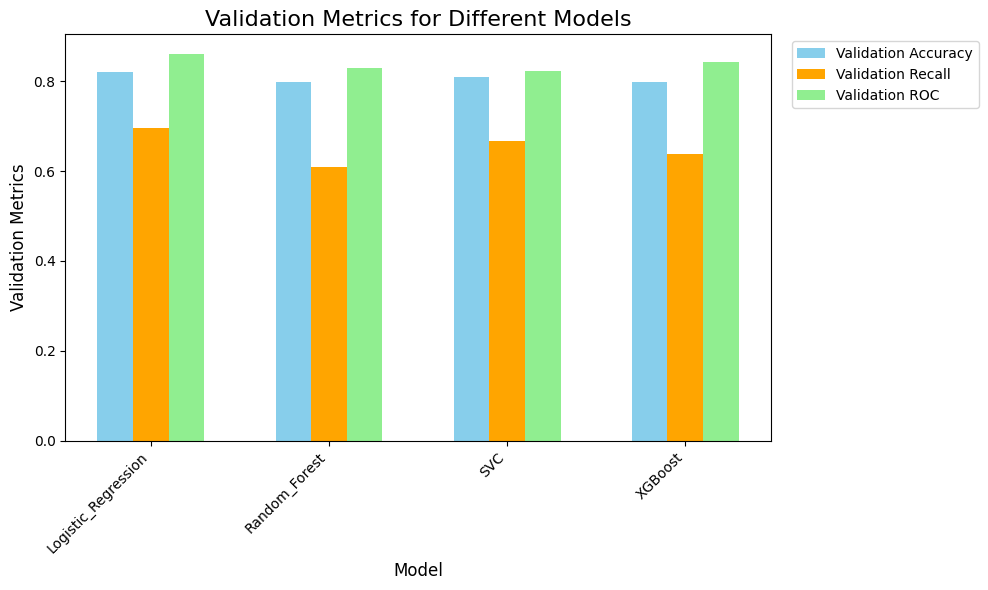

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = df_results.index
validation_accuracy = df_results['validation_accuracy']
validation_recall = df_results['validation_recall']
validation_roc = df_results['validation_roc']

# Plot the side-by-side bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(models))

bar1 = plt.bar(index - bar_width, validation_accuracy, bar_width, label='Validation Accuracy', color='skyblue')
bar2 = plt.bar(index, validation_recall, bar_width, label='Validation Recall', color='orange')
bar3 = plt.bar(index + bar_width, validation_roc, bar_width, label='Validation ROC', color='lightgreen')

# Set the labels and title
plt.xlabel('Model', fontsize=12)
plt.ylabel('Validation Metrics', fontsize=12)
plt.title('Validation Metrics for Different Models', fontsize=16)
plt.xticks(index, models, rotation=45, ha='right')

# Place the legend outside the plot box
plt.legend(handles=[bar1, bar2, bar3], labels=['Validation Accuracy', 'Validation Recall', 'Validation ROC'],
           bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()

# Display the plot
plt.show()


In [41]:
test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_N,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,0.411090,-0.474636,-0.479827,-0.530314,0,1,0,0,1,0,0,0,1,0,0
1,3,1.338361,0.396345,-0.479827,-0.548984,1,0,0,0,0,1,0,0,0,1,0
2,2,2.451087,-0.474636,-0.479827,-0.488474,0,1,0,0,1,0,0,0,1,0,0
3,3,-0.145272,-0.474636,-0.479827,-0.511552,0,1,0,0,0,1,0,0,1,0,0
4,3,-0.516180,0.396345,0.749082,-0.429934,1,0,0,0,0,1,0,0,0,1,0


We can see that logistics worked best. So we will do the final prediction using that only

In [42]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pclass        418 non-null    int64  
 1   Age           418 non-null    float64
 2   SibSp         418 non-null    float64
 3   Parch         418 non-null    float64
 4   Fare          417 non-null    float64
 5   Sex_female    418 non-null    uint8  
 6   Sex_male      418 non-null    uint8  
 7   Embarked_C    418 non-null    uint8  
 8   Embarked_N    418 non-null    int64  
 9   Embarked_Q    418 non-null    uint8  
 10  Embarked_S    418 non-null    uint8  
 11  Title_Master  418 non-null    uint8  
 12  Title_Miss    418 non-null    uint8  
 13  Title_Mr      418 non-null    uint8  
 14  Title_Mrs     418 non-null    uint8  
 15  Title_Rare    418 non-null    uint8  
dtypes: float64(4), int64(2), uint8(10)
memory usage: 23.8 KB


In [43]:
# Check for missing values in the test DataFrame
missing_values = test.isnull().sum()

# Print the columns with missing values (if any)
print(missing_values[missing_values > 0])


Fare    1
dtype: int64


In [44]:
from sklearn.impute import SimpleImputer

# Convert 'nan' strings to actual NaN values
test['Fare'] = test['Fare'].replace('nan', np.nan)

# Group by "Pclass" and calculate the median fare for each passenger class
fare_median_by_pclass = test.groupby("Pclass")["Fare"].median()

# Function to impute missing "Fare" values based on passenger class
def impute_fare_by_pclass(row):
    if pd.isnull(row["Fare"]):
        return fare_median_by_pclass[row["Pclass"]]
    else:
        return row["Fare"]

# Apply the imputation function to fill missing "Fare" values
test["Fare"] = test.apply(impute_fare_by_pclass, axis=1)


In [45]:
# Get the predictions on test data using logistic_best_model
y_test= logistic_best_model.predict(test)


In [46]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': y_test})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
